# Extorr RGA Data Analysis program
## The purpose of this program is to analyze experimental data acquired by Extorr RGA systems
### By Jephthah Akene
# __

# Analysis process is as follows
* Import all required library for data processing and visualization
    * Numpy for array manipulation
    * Pandas for DataFrame manipulation
    * scipy for advanced arithmetics - Integration and interpolation
    * datetime for time manipulation
    * Matplotlib for data visualization
* Import the extorr data file
    * Read data as a csv file or table
    * Skip meta data rows (0-137)
    * Designate comma delimiter
    * Designate columns of interest
    * Name columns - Time, Mass, Pressure
* Perform Time manioulation
    * Format time into time object
    * Calculate the time delta between data points
    * Convert the time delta into seconds
    * Add the new time data to the data frame
* Begin data grouping process
    * Group data by mass of interest (centroid grouping) - dump group into a new data sheet
    * Bin data by mass ranges around specified masses ( ranged grouping) - dump group into a new data sheet
* Calculate mass pressures every bin width. i.e sum every n rows where n is the bin width
* Plot centroid group over range group for comparison. Range grouping improves statistics

# ___________________________________________________________________

# Step 1 : Import all required libraries 

In [1]:
import numpy as np # for array manipulation and mathematics
import pandas as pd # for data frame and array manipulation
import matplotlib.pyplot as plt # for plotting data frames (data sets)
from scipy import integrate # advanced library for integrating under a curve or data set
from scipy.interpolate import interp1d, PchipInterpolator # advanced library for interpolation
from scipy import interpolate # yet another interpolation from the scipy library
import datetime as dt # for converting the date time columns into date time objects
from datetime import datetime # creating date time objects
import plotly.express as px
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0) # setting the plot figure size

# __ 
# Step 2 : Import extorr data file 
    * Read data as a csv file or table
    * Skip meta data rows (0-137)
    * Designate comma delimiter
    * Designate columns of interest
    * Name columns - Time, Mass, Pressure

In [2]:
exDf = pd.read_table('C:\\Users\\jakene\\Documents\\Python_Projects\\jupyter_notebooks\\CLASSE Data Analysis\\Data\\02242020\\Extorr\\20200224_butaneandwater_sputtering.csv',
                    skiprows = 137,
                     delimiter = ',',
                     usecols = [0,1,2],
                     names = ['Time','Mass','Pressure'],
                    )

In [3]:
print (exDf) # peak at the top and bottom of the data frame for confirmation

                           Time  Mass      Pressure
0       2020/02/24 17:23:43.390   0.6  1.520600e-07
1       2020/02/24 17:23:43.490   0.7  1.447700e-07
2       2020/02/24 17:23:43.590   0.8  1.536100e-07
3       2020/02/24 17:23:43.690   0.9  4.735100e-07
4       2020/02/24 17:23:43.790   1.0  8.450400e-07
...                         ...   ...           ...
546177  2020/02/25 08:37:30.161  18.3  1.485300e-07
546178  2020/02/25 08:37:30.261  18.4  8.855100e-08
546179  2020/02/25 08:37:30.361  18.5  8.797000e-10
546180  2020/02/25 08:37:30.461  18.6  3.174400e-09
546181  2020/02/25 08:37:30.561  18.7  5.062100e-09

[546182 rows x 3 columns]


# __
# Step 3 : Perform Time manipulation
    * Format time into time object
    * Calculate the time delta between data points
    * Convert the time delta into seconds
    * Add the new time data to the data frame

In [4]:
exDf.Time = pd.to_datetime(exDf.Time, errors = 'coerce', format='%Y-%m-%d %H:%M:%S.%f') # convert time to time object

In [5]:
exDf['delT'] = exDf.Time - exDf.Time.iloc[0] # Calculate time delta

In [6]:
exDf['delT_Sec'] = exDf.delT.dt.total_seconds() # Convert time delta to total seconds since first time stamp

In [7]:
exDf = exDf[['Time','delT','delT_Sec','Mass','Pressure']] # Add the new variables to the data frame

In [8]:
exDf # peak at the top and bottom of the data frame for confirmation

,Time,delT,delT_Sec,Mass,Pressure
0,2020-02-24 17:23:43.390,00:00:00,0.000,0.6,1.520600e-07
1,2020-02-24 17:23:43.490,00:00:00.100000,0.100,0.7,1.447700e-07
2,2020-02-24 17:23:43.590,00:00:00.200000,0.200,0.8,1.536100e-07
3,2020-02-24 17:23:43.690,00:00:00.300000,0.300,0.9,4.735100e-07
4,2020-02-24 17:23:43.790,00:00:00.400000,0.400,1.0,8.450400e-07
...,...,...,...,...,...
546177,2020-02-25 08:37:30.161,15:13:46.771000,54826.771,18.3,1.485300e-07
546178,2020-02-25 08:37:30.261,15:13:46.871000,54826.871,18.4,8.855100e-08
546179,2020-02-25 08:37:30.361,15:13:46.971000,54826.971,18.5,8.797000e-10
546180,2020-02-25 08:37:30.461,15:13:47.071000,54827.071,18.6,3.174400e-09


# __
# Step 4 : Begin data grouping process
    * Group data by mass of interest (centroid grouping) - dump group into a new data sheet
    * Bin data by mass ranges around specified masses ( ranged grouping) - dump group into a new data sheet
        * Calculate mass pressures every bin width. i.e sum every n rows where n is the bin width

### Centroid Mass grouping

In [9]:
# Centroid grouping specified Masses 
massGroups = exDf.groupby('Mass')
m2 = massGroups.get_group(2).reset_index().rename(columns={'index': 'original_index'})
m12 = massGroups.get_group(12).reset_index().rename(columns={'index': 'original_index'})
m14 = massGroups.get_group(14).reset_index().rename(columns={'index': 'original_index'})
m18 = massGroups.get_group(18).reset_index().rename(columns={'index': 'original_index'})
m32 = massGroups.get_group(32).reset_index().rename(columns={'index': 'original_index'})
m44 = massGroups.get_group(44).reset_index().rename(columns={'index': 'original_index'})
m52 = massGroups.get_group(52).reset_index().rename(columns={'index': 'original_index'})
m58 = massGroups.get_group(58).reset_index().rename(columns={'index': 'original_index'})

In [10]:
m2 # Peak inside mass 2 filtered data frame

,original_index,Time,delT,delT_Sec,Mass,Pressure
0,14,2020-02-24 17:23:44.790,00:00:01.400000,1.400,2.0,9.482700e-07
1,1014,2020-02-24 17:25:25.231,00:01:41.841000,101.841,2.0,8.742800e-07
2,2014,2020-02-24 17:27:05.675,00:03:22.285000,202.285,2.0,1.084300e-06
3,3014,2020-02-24 17:28:46.029,00:05:02.639000,302.639,2.0,8.386200e-07
4,4014,2020-02-24 17:30:26.602,00:06:43.212000,403.212,2.0,1.271800e-06
...,...,...,...,...,...,...
542,542014,2020-02-25 08:30:32.400,15:06:49.010000,54409.010,2.0,9.549200e-07
543,543014,2020-02-25 08:32:12.755,15:08:29.365000,54509.365,2.0,1.040400e-06
544,544014,2020-02-25 08:33:53.154,15:10:09.764000,54609.764,2.0,8.435300e-07
545,545014,2020-02-25 08:35:33.507,15:11:50.117000,54710.117,2.0,1.251600e-06


### Range Mass grouping

In [11]:
# Ranged grouping specified Masses - create bins to hold the mass ranges 
exDf['m2bins'] = pd.cut(x=exDf['Mass'],bins=[1.5,2.4])
exDf['m12bins'] = pd.cut(x=exDf['Mass'],bins=[11.5,12.4])
exDf['m14bins'] = pd.cut(x=exDf['Mass'],bins=[13.5,14.4,])
exDf['m18bins'] = pd.cut(x=exDf['Mass'],bins=[17.5,18.4])
exDf['m32bins'] = pd.cut(x=exDf['Mass'],bins=[31.5,32.4])
exDf['m44bins'] = pd.cut(x=exDf['Mass'],bins=[43.5,44.4])
exDf['m52bins'] = pd.cut(x=exDf['Mass'],bins=[51.5,52.4])
exDf['m58bins'] = pd.cut(x=exDf['Mass'],bins=[57.5,58.4])

In [12]:
# Drop NAN values in data frame. these NAN occur when values bo not meet binning criteria for each mass
m2r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m2bins']].dropna().reset_index().rename(columns={'index': 'original_index'})
m12r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m12bins']].dropna().reset_index().rename(columns={'index': 'original_index'})
m14r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m14bins']].dropna().reset_index().rename(columns={'index': 'original_index'})
m18r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m18bins']].dropna().reset_index().rename(columns={'index': 'original_index'})
m32r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m32bins']].dropna().reset_index().rename(columns={'index': 'original_index'})
m44r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m44bins']].dropna().reset_index().rename(columns={'index': 'original_index'})
m52r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m52bins']].dropna().reset_index().rename(columns={'index': 'original_index'})
m58r = exDf[['Time','delT','delT_Sec','Mass','Pressure','m58bins']].dropna().reset_index().rename(columns={'index': 'original_index'})

In [13]:
m2r

,original_index,Time,delT,delT_Sec,Mass,Pressure,m2bins
0,10,2020-02-24 17:23:44.390,00:00:01,1.000,1.6,7.044200e-07,"(1.5, 2.4]"
1,11,2020-02-24 17:23:44.490,00:00:01.100000,1.100,1.7,7.200500e-07,"(1.5, 2.4]"
2,12,2020-02-24 17:23:44.590,00:00:01.200000,1.200,1.8,7.472600e-07,"(1.5, 2.4]"
3,13,2020-02-24 17:23:44.690,00:00:01.300000,1.300,1.9,8.002200e-07,"(1.5, 2.4]"
4,14,2020-02-24 17:23:44.790,00:00:01.400000,1.400,2.0,9.482700e-07,"(1.5, 2.4]"
...,...,...,...,...,...,...,...
4918,546014,2020-02-25 08:37:13.861,15:13:30.471000,54810.471,2.0,7.247000e-07,"(1.5, 2.4]"
4919,546015,2020-02-25 08:37:13.961,15:13:30.571000,54810.571,2.1,8.541700e-07,"(1.5, 2.4]"
4920,546016,2020-02-25 08:37:14.061,15:13:30.671000,54810.671,2.2,9.140500e-07,"(1.5, 2.4]"
4921,546017,2020-02-25 08:37:14.161,15:13:30.771000,54810.771,2.3,8.240200e-07,"(1.5, 2.4]"


# __
# Step 5 : Calculate mass pressures every bin width. i.e sum every n rows where n is the bin width

In [14]:
m2r_agg = m2r.groupby(m2r.index // 9 ).mean()
m12r_agg = m12r.groupby(m12r.index // 9 ).mean()
m14r_agg = m14r.groupby(m14r.index // 9 ).mean()
m18r_agg = m18r.groupby(m18r.index // 9 ).mean()
m32r_agg = m32r.groupby(m32r.index // 9 ).mean()
m44r_agg = m44r.groupby(m44r.index // 9 ).mean()
m52r_agg = m52r.groupby(m52r.index // 9 ).mean()
m58r_agg = m58r.groupby(m58r.index // 9 ).mean()

In [15]:
m2r_agg

,original_index,delT_Sec,Mass,Pressure
0,14,1.400,2.0,8.174689e-07
1,1014,101.841,2.0,8.339689e-07
2,2014,202.285,2.0,8.208100e-07
3,3014,302.639,2.0,8.131467e-07
4,4014,403.212,2.0,8.157300e-07
...,...,...,...,...
542,542014,54409.010,2.0,7.981956e-07
543,543014,54509.365,2.0,8.075556e-07
544,544014,54609.764,2.0,7.801778e-07
545,545014,54710.117,2.0,8.227511e-07


# __
# Step 6 : Plot centroid group over range group for comparison. Range grouping improves statistics

Text(0, 0.5, 'Pressure')

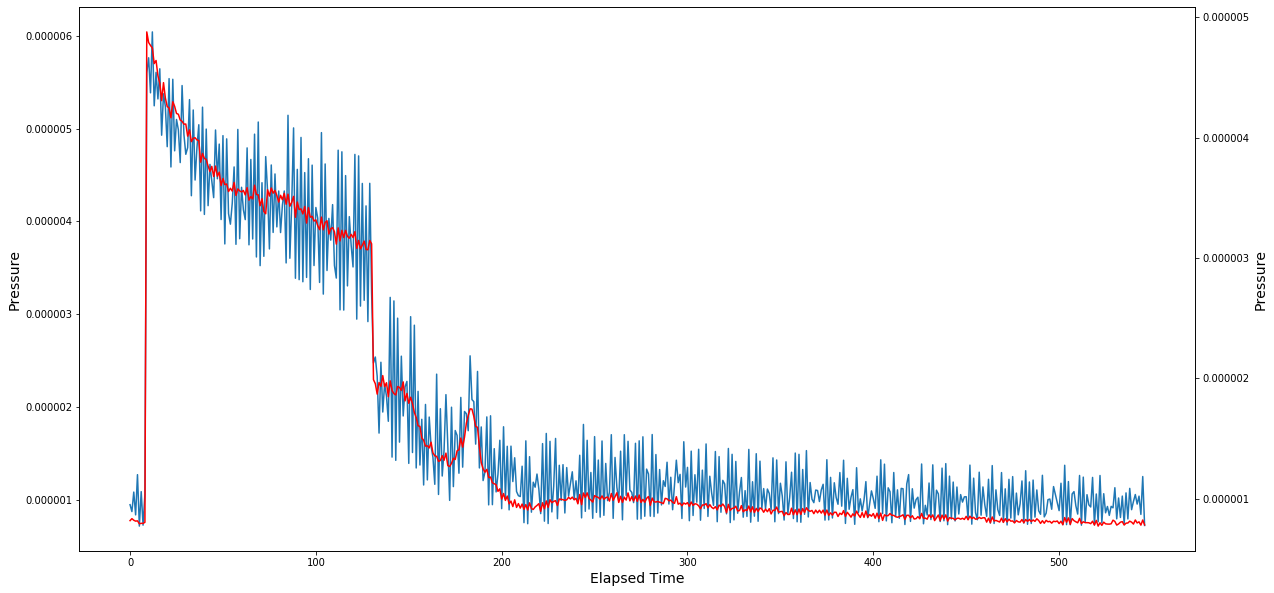

In [17]:
# Demostration of Ploting mass centroid over binned data
fig,mass_ax = plt.subplots()
mass_ax.plot(m2.index,m2.Pressure)
mass_ax.set_xlabel("Elapsed Time", fontsize=14)
mass_ax.set_ylabel("Pressure", fontsize=14)

massr_ax = mass_ax.twinx()
massr_ax.plot(m2r_agg.index,m2r_agg.Pressure, color = 'r')
massr_ax.set_xlabel("Elapsed Time", fontsize=14)
massr_ax.set_ylabel("Pressure", fontsize=14)

# Implementing this program with ORACLE chamber data

### The Chamber data sheet contains data generated by ORALCE. The ORACLE system has it's own clock and appends a PC TIME/Elapsed time for each data point acquired to the data sheet. 
### Since Extorr also has it's own time column, and we know that we would have manipulate the extorr/chamber data time column. 
### We would have to perform the extorr time manipulation and first before performing advanced data manipulation. 

### Step 1: Import Extorr data 
### Step 2: Perform pre data analysis clean up
### Step 3: Create a new column on the extorr data frame containing relative elapsed time (relative elapsed time is the time difference between extorr and the chamber data's first time stamp)
### Step 4: Perform Grouping and follow through with Step 4 - 6 on this program